id                 float64
minute               int64
result              object
X                  float64
Y                  float64
xG                 float64
player              object
h_a                 object
player_id            int64
situation           object
year                 int64
shotType            object
match_id             int64
h_team              object
a_team              object
h_goals              int64
a_goals              int64
date                object
player_assisted     object
lastAction          object
dtype: object
                  id         minute              X              Y  \
count  292070.000000  292070.000000  292070.000000  292070.000000   
mean   180836.924624      48.571801       0.843213       0.504781   
std    115471.138400      26.582925       0.089319       0.130116   
min         1.000000       0.000000       0.003000       0.000000   
25%     83240.250000      26.000000       0.779000       0.413000   
50%    164120.500000      49.000

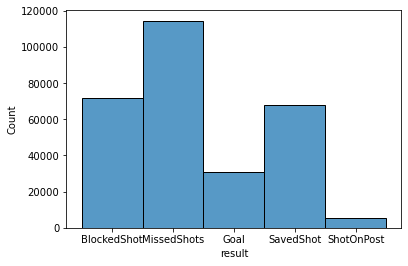

In [21]:
import pandas as pd
import numpy as np

target = 'result'

df = pd.read_csv('FullShotsData.csv')

print(df.dtypes)

print(df.describe())

print(df.shape)

df = df[df.result != 'OwnGoal']

import seaborn as sns

sns.histplot(df['result'])

baseline = df[target].value_counts(normalize = True)

print(f' baseline model : {baseline[0]:.2f}')

print(df['lastAction'].value_counts())

df_edited = df.drop(labels=['id','minute','player','player_id','year','match_id','h_team','a_team','h_goals','a_goals','date','player_assisted'],axis=1)

In [22]:
lastActionList = df_edited['lastAction'].value_counts()
k = lastActionList.index
klist = k[21:]

def lastActionMod(x):

    if x in klist:

        x = 'etc'
        return x
    else:

        return x
    
    return x

def resultMod(x):

    if x != 'Goal':

        return 'NoGoal'
    else:

        return x
    
    return x

df_edited['lastAction'] = df_edited['lastAction'].apply(lastActionMod)
df_edited['result'] = df_edited['result'].apply(resultMod)

<AxesSubplot:xlabel='result', ylabel='Count'>

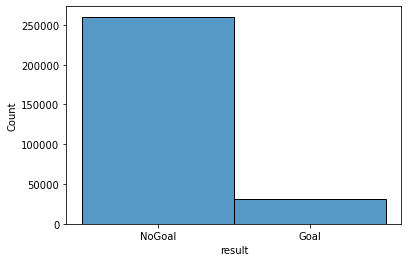

In [23]:
sns.histplot(df_edited['result'])

In [35]:
baseline = df_edited[target].value_counts(normalize = True)

print(f' baseline model : {baseline[0]:.2f}')

 baseline model : 0.89


In [24]:
from xgboost import XGBClassifier
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([
    ('pre',make_pipeline(OrdinalEncoder(),  
    SimpleImputer())), 
    ('rf',XGBClassifier(n_estimators=200
                  , random_state=42
                  , learning_rate=0.2
                 ))]
)

In [25]:
from random import randint
from sklearn.model_selection import RandomizedSearchCV

dists = {
    'rf__subsample' : np.linspace(0.4, 1, 5),
    'rf__max_depth' : list(range(2,10))

}

clf = RandomizedSearchCV(
    pipe,
    param_distributions=dists,
    scoring='f1_micro',
    n_iter=5,
    cv=5,
    n_jobs=8,
    return_train_score=True
)

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

feature = df_edited.drop(labels='result',axis=1).columns

X_train, X_test, y_train, y_test = train_test_split(df_edited[feature],df_edited[target], stratify=(df_edited['result']),random_state=(42))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

clf.fit(X_train, y_train)

c:\Users\jg020\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:41:59] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pre',
                                              Pipeline(steps=[('ordinalencoder',
                                                               OrdinalEncoder()),
                                                              ('simpleimputer',
                                                               SimpleImputer())])),
                                             ('rf',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            enable_categorical=False,
                                                        

In [27]:
clf_df = pd.DataFrame(clf.cv_results_)
clf_df[clf_df['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__subsample,param_rf__max_depth,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,8.228664,0.403377,0.299468,0.029655,0.85,3,"{'rf__subsample': 0.85, 'rf__max_depth': 3}",0.906327,0.907853,0.908952,...,0.908243,0.001098,1,0.910378,0.909959,0.909776,0.9096,0.909891,0.909921,0.000259


In [28]:
print(clf.best_score_)

0.9082434977451062


In [29]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
y_pred = clf.best_estimator_.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))

print(classification_report(y_pred, y_val))

검증 정확도:  0.9057595458291365
              precision    recall  f1-score   support

        Goal       0.26      0.65      0.38      2375
      NoGoal       0.98      0.92      0.95     52230

    accuracy                           0.91     54605
   macro avg       0.62      0.78      0.66     54605
weighted avg       0.95      0.91      0.92     54605



In [30]:
print(clf.cv_results_)

{'mean_fit_time': array([14.11251936,  7.58148217,  8.22866406, 20.98356915, 12.79920597]), 'std_fit_time': array([0.89633941, 0.68718378, 0.40337693, 0.72799853, 2.64153737]), 'mean_score_time': array([0.33787642, 0.27046108, 0.29946795, 0.32388954, 0.31647191]), 'std_score_time': array([0.0411306 , 0.01129122, 0.02965489, 0.01724099, 0.06914346]), 'param_rf__subsample': masked_array(data=[1.0, 0.4, 0.85, 1.0, 0.7],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_rf__max_depth': masked_array(data=[6, 3, 3, 9, 6],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'rf__subsample': 1.0, 'rf__max_depth': 6}, {'rf__subsample': 0.4, 'rf__max_depth': 3}, {'rf__subsample': 0.85, 'rf__max_depth': 3}, {'rf__subsample': 1.0, 'rf__max_depth': 9}, {'rf__subsample': 0.7, 'rf__max_depth': 6}], 'split0_test_score': array([0.9058389 , 0.90538107, 0.90632726, 0.90586943, 0.

In [31]:
from sklearn.metrics import confusion_matrix

y_pred = clf.best_estimator_.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_pred, y_test))

[[ 2133  5593]
 [ 1066 64015]]
              precision    recall  f1-score   support

        Goal       0.28      0.67      0.39      3199
      NoGoal       0.98      0.92      0.95     69608

    accuracy                           0.91     72807
   macro avg       0.63      0.79      0.67     72807
weighted avg       0.95      0.91      0.93     72807



In [32]:
import eli5
from eli5.sklearn import PermutationImportance
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
model = clf.best_estimator_
permuter = PermutationImportance(
    model.named_steps['rf'], 
    scoring='accuracy', 
    n_iter=5,
    random_state=2
)
X_val_transformed = model.named_steps['pre'].transform(X_val)
permuter.fit(X_val_transformed, y_val)

PermutationImportance(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1,
                                              enable_categorical=False, gamma=0,
                                              gpu_id=-1, importance_type=None,
                                              interaction_constraints='',
                                              learning_rate=0.2,
                                              max_delta_step=0, max_depth=3,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=200, n_jobs=16,
                                              num_parallel_tree=1,
                                              predi

In [33]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

situation    -0.000121
h_a          -0.000051
shotType      0.000084
Y             0.000220
lastAction    0.000300
X             0.001044
xG            0.042264
dtype: float64

In [34]:

eli5.show_weights(
    permuter, 
    top=None, 
    feature_names=feature_names
)

Weight,Feature
0.0423 ± 0.0008,xG
0.0010 ± 0.0004,X
0.0003 ± 0.0001,lastAction
0.0002 ± 0.0003,Y
0.0001 ± 0.0002,shotType
-0.0001 ± 0.0001,h_a
-0.0001 ± 0.0002,situation


In [46]:
import shap

explainer = shap.TreeExplainer(model.named_steps['rf'])
X_val_sample = X_val.sample(n=500, random_state=42)
X_val_sample_transformed = model.named_steps['pre'].transform(X_val_sample)
shap_values = explainer.shap_values(X_val_sample_transformed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=X_val
)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


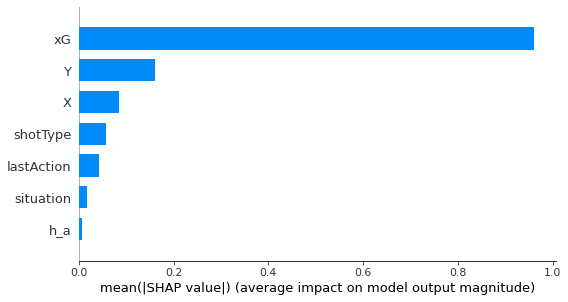

In [48]:
shap.summary_plot(shap_values, X_val, plot_type='bar')